# Working with GeoPandas and PySAL

We've worked -- and will continue to work -- a lot with pandas, but by default pandas doesn't help us much when want to start working with explicitly geographical data. Ways of working _computationally_ with things like distance and location are increasingly important not only to geographers, but also to data scientists, and this is where we start to move away from purely aspatial statistical analysis into the foundations of a more _geographic_ data science.

There are a huge number of modules in Python designed to help you work with geodata, but we are going to focus on the two most important higher-level libraries (since they also provide 'wrappers' around some of the lower-level libraries):

1. [GeoPandas](http://geopandas.org/) -- which offers a pandas-like interface to working with geodata. Think of this as your tool for basic data manipulation and transformation, much like pandas. You will almost certainly want to [bookmark the documentation](http://geopandas.org/user.html#geodataframe).
2. [PySAL](http://pysal.readthedocs.io/en/latest/) -- the Python Spatial Analysis Library  provides the spatial analytic functions that we'll need for everything from classification, clustering and point-pattern analysis to autocorrelation-based tools.
3. There is some overlap between the two libraries: both can do plotting but, for reasons we'll see later, we'll normally do this in PySAL and both can do classification (remember, we did _quantiles_ with pandas!) but (again), for reasons we'll see later, we'll often do this in PySAL from here on out.

PySAL is complicated enough that the best way to understand how it fits together is to use an image:

![PySAL Logo](http://darribas.org/gds_scipy16/content/figs/pysal.png)

We're going to concentrate primarily on the ESDA (Exploratory _Spatial_ Data Analysis) and Weights components of PySAL in this module, but you should know about the other bits!

## A (Semi-Brief) Discourse on Families & Inheritance

GeoPandas objects are deliberately designed to resemble Pandas objects. There are two good reasons for this: 

1. Since Pandas is well-known, this makes it easier to learn how to use GeoPandas.
2. GeoPandas _inherits_ functionality from Pandas. 

The concept of **inheritance** is something we've held off from mentioning until now, but it's definitely worth understanding if you are serious about learning how to code. In effect, geopandas '_imports_' pandas and then _extends_ it so that the more basic class (pandas in this case) learns how to work with geodata... pandas doesn't know how to read shapefiles or make maps, but geopandas does. Same for GeoJSON.

### The 'Tree of Life'

Here's a simple way to think about inheritance: think of the 'evolutionary trees' you might have seen charting the evolution of organisms over time. At the bottom of the tree is the single-celled animal, and at the other end are humans, whales, wildebeest, etc. We all _inherit_ some basic functionality from that original, simple cell. In between us and that primitive, however, are a whole series of branches: different bits of the tree evolved in different directions and developed different 'functionality'. Some of us have bones. Some have  cartilege. Some are vegetarian, and some are carnivorous. And so on. When you get to the primates we all share certain common 'features' (binocular vision, grasping hands, etc.), but we are _still_ more similar to gorillas than we are to macaques. So gorillas and humans _extend_ the primitive 'primate functionality' with some bonus features (bigger brains, greater strength, etc.) that are useful, while macaques extend it with a slightly different set of features (tails, etc.).

![Tree of Life](http://palaeos.com/systematics/tree/images/treeolif.jpg)

### The 'Tree of Classes'

Inheritance in code works in a similar way: *all* Python classes (lists, pandas, plots, etc.) inherit their most basic functionality from a single primitive 'object' class that itself does very little except to provide a template for what an object should look like. As you move along the inheritance tree you will find more and more complex objects with increasingly advanced features: GeoPandas inherits from Pandas, Bokeh and Seaborn inherit from matplotlib, etc. 

I can't find an image of Python base class inheritance, but I've found an equally useful example of how _anything_ can be modelled using this 'family tree' approach... consider the following:

![Vehicle Inheritance](http://www.mkonar.org/dogus/wiki/lib/exe/fetch.php/python/vehicle.png?w=750&tok=4c7ed7)

If we were trying to implement a vehicle registration scheme in Python, we would want to start with the most basic category of all: _vehicle_. The vehicle class itself might not do much, but it gives us a template for _all_ vehicles (e.g. it must be registered, it must have a unique license number, etc.). We then _extend_ the functionality of this 'base class' with three intermediate classes: two-wheeled vehicles, cars, and trucks. These, in turn, lead to eight actual vehicle types. These might have _additional_ functionality: a bus might need have a passenger capacity associated with it, while a convertible might need to be hard- or soft-top. All of this could be expressed in Python as:

```python
class vehicle(object): # Inherit from base class
    def __init__(self):
        ... do something ...

class car(vehicle): # Inherit from vehicle
    def __init__(self):
        ... do other stuff ...

class sedan(car): # Inherit from car
    def __init__(self):
        ... do more stuff ...
```

This way, when we create a new `sedan`, it automatically 'knows' about vehicles and cars, and can make use of functions like `set_unique_id(<identification>)` even if that function is _only_ specified in the base vehicle class! The thing to remember is that programmers are _lazy_: if they can avoid reinventing the wheel, they will. Object-Oriented Programming using inheritance is a good example of _constructive_ laziness: it saves us having to constantly copy and paste code (for registering a new vehicle or reading in a CSV file) from one class to the next since we can just import it and _extend_ it! 

### Advantages of Inheritance \#1

This also means that we are less likely to make mistakes: if we want to update our vehicle registration scheme then we don't need to update lots of functions all over the place, we just update the base class and _all_ inheriting classes automatically gain the update because they are making use of the base class' function. 

So if pandas is updated with a new 'load a zip file' feature then geopandas automatically benefits from it! The _only_ thing that doesn't gain that benefit immediately is our ability to make use of specifically geographical data because pandas doesn't know about that type of data, only 'normal' tabular data.

### Advantages of Inheritance \#2

Inheritance also means that you can always use an instance of a 'more evolved' class in place of one of its ancestors: simplifying things a _bit_, a sedan can automatically do anything that a car can do and, by extension, anything that a vehicle can do. 

Similarly, since geopandas inherits from pandas if you need to use a geopandas object _as if_ it's a pandas object then that will work! So everything you learned last term for pandas can still be used in geopandas. Kind of cool, right?

### Designing for Inheritance

Finally, looking back at our example above: what about unicycles? Or tracked vehicles like a tank? This is where _design_ comes into the picture: when we're planning out a family tree for our work we need to be careful about what goes where. And there isn't always a single right answer: perhaps we should distinguish between pedal-powered and motor-powered (in which case unicycles, bicycles and tricycles all belong in the same family)? Or perhaps we need to distinguish between wheeled and tracked (in which case we're missing a pair of classes [wheeled, tracked] between 'vehicle' and 'two-wheel, car, truck')? These choices are tremendously important but often very hard to get right.

OK, that's enough programming theory, let's see this in action...

## Required Preamble

It makes life a lot easier if you make all of the library import commands and configuration information (here having to do with `matplotlib`) the first exectuable code in a notebook or script. That way it's easy to see what you need to have installed before you get started!

You'll notice that I've broken my own 'rule' a little later when we get to PySAL but that's because I didn't want you to have no idea where some of the commands are coming from!

In [1]:
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pysal as ps
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import urllib
import zipfile
import re
import os

# Make numeric display a bit easier
pd.set_option('display.float_format', lambda x: '{:,.0f}'.format(x))

## Getting the Data

We're going to work with three data sets this week:

1. The LSOA CSV data we've been using already.

2. A zipfile containing LSOA _geometries_.

3. A gzip file containing data [scraped from Airbnb](http://insideairbnb.com/get-the-data.html).

Let's see about automation...

In [3]:
def download_gsa_data(src='http://bit.ly/2g4Iz3v', dst='lsoa.csv.gz', srczip='gzip'):
    """
    A simple function to help simplify the process of downloading
    and saving data to use in a practical. To save on bandwidth, 
    the function will first check whether a local copy of the file
    exists (as specified by the dst parameter) before attempting to
    read it from the remote source (as specified by the src parameter).
    
    
    Keyword arguments:
    src -- a remote URL to use as a source (default http://bit.ly/2g4Iz3v)
    dst -- a local path to use as a destination (default lsoa.csv.gz)
    """
    dst_compression='gzip'
    
    # Check if local copy exists...
    if os.path.exists(dst):
        # Yes, then just read and return the data frame
        print("File already downloaded.")
        # The 'low memory' option means pandas doesn't guess data types
        df = pd.read_csv(dst, compression=dst_compression, low_memory=False)
        
    else:
        # No, then download and save a local copy
        print("Downloading remote data...")
        
        # It is possible to have a remote file with no
        # compression so this is just a piece of forward
        # looking code....
        if srczip is not None:
            # The 'low memory' option means pandas doesn't guess data types
            df = pd.read_csv(src, compression=srczip, low_memory=False)
        else:
            df = pd.read_csv(src, low_memory=False)
        
        # And save it
        print("Writing to local file...")
        df.to_csv(dst, compression=dst_compression, index=False)
    print("Done.")
    return df

df = download_gsa_data()
df.set_index(['LSOA11CD'], drop=True, inplace=True)

File already downloaded.
Done.


In [4]:
src = 'https://github.com/kingsgeocomp/geocomputation/blob/master/data/LSOAs.zip?raw=true'
dst = 'shapes/LSOAs.zip'
zpd = 'shapes/'

if not os.path.exists(dst):
    if not os.path.exists(os.path.dirname(dst)):
        os.makedirs(os.path.dirname(dst))
    urllib.urlretrieve(src, dst)

if not os.path.exists(zpd):
    os.makedirs(os.path.dirname(zpd))
    
zp = zipfile.ZipFile(dst, 'r')
zp.extractall(zpd)
zp.close()    

print("Done.")

Done.


## Reading a Shapefile with GeoPandas

_Remember:_ as long as you have saved the file to somewhere accessible to Jupyter (i.e. a directory _beneath_ the current one where you are working) then you can find out the 'path' to a file by switching to the 'Home' tab in your browser and navigating to the file. You can _also_ find out where the current Notebook is running like this:

In [ ]:
!pwd # !cd on Windows

In other words, depending on your setup you might need to tweak the path in the code below to get your own code working...

In [6]:
gdf = gpd.read_file( 
    os.path.join('shapes','lsoas','Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.shp') 
)

gdf.head(3)

,objectid,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,geometry
0,1,E01000001,City of London 001A,City of London 001A,"133,321","2,292","POLYGON ((532106.8939689073 182011.4758723566,..."
1,2,E01000002,City of London 001B,City of London 001B,"226,191","2,434","POLYGON ((532748.6236845022 181787.1247154782,..."
2,3,E01000003,City of London 001C,City of London 001C,"57,303","1,142","POLYGON ((532136.9496997485 182198.3681596624,..."


So far so good! Notice that even the output of the `head` function is the same as from pandas. The only obvious difference so far is that `geometry` column on the right-hand side which doesn't contain numbers or strings, but `POLYGON`s. In a nutshell, aside from the ability to read geodata directly (we just loaded a shapefile using only code!) this geometry column is the other marker of a big step from pandas to geopandas.

But let's dig a little deeper:

In [7]:
print("Let's look at inheritance: ")

if isinstance(gdf, gpd.GeoDataFrame): # Is gdf a GeoDataFrame object?
    print("\tI'm a geopandas data frame!")

if isinstance(gdf, pd.DataFrame): # Is gdf *also* a DataFrame object?
    print("\tI'm also a pandas data frame!")

print("-" * 50)

print("Let's look at some pandas methods we know: ") # See inheritance in action

print("Using the 'sample()' method: ")
print(gdf.sample(3))
print("-" * 50)

print("What the lsoa11nm column type: ")
print('\tNAME type: ' + str(type(gdf.lsoa11nm)))
print("-" * 50)

print("Describe the column: ")
print(gdf.lsoa11nm.describe())
print("-" * 50)

print("Let's look at some new methods from geopandas: ") # Here's stuff pandas can't do

print("What's the geometry column type: ")
print('\tGeometry type: ' + str(type(gdf.geometry)))
print("-" * 50)

# The next line is very slow, don't run it:
# print(gdf.geometry.describe())
# print("-" * 50)

print("Is there projection information: ")
print('\tCRS: ' + str(gdf.crs))
print("-" * 50)

print("Help with the centroid method of the GeoSeries (geometry) column: ")
help(gdf.geometry.centroid)

Let's look at inheritance: 
	I'm a geopandas data frame!
	I'm also a pandas data frame!
--------------------------------------------------
Let's look at some pandas methods we know: 
Using the 'sample()' method: 
      objectid   lsoa11cd             lsoa11nm            lsoa11nmw  \
4222      4223  E01004331  Waltham Forest 028E  Waltham Forest 028E   
5615     21351  E01021938        Rochford 003F        Rochford 003F   
5503     21190  E01021775   Epping Forest 011B   Epping Forest 011B   

      st_areasha  st_lengths  \
4222     107,027       1,782   
5615     312,005       3,125   
5503   1,383,660       6,567   

                                               geometry  
4222  POLYGON ((540218.4432555377 185919.5019429213,...  
5615  POLYGON ((584492.964469534 192994.3687311954, ...  
5503  POLYGON ((545058.8294609456 197589.854110383, ...  
--------------------------------------------------
What the lsoa11nm column type: 
	NAME type: <class 'pandas.core.series.Series'>
----------

This next command may take a while to complete -- the geopandas developers know that their mapping code is sloooooooooow, and that's one of the reasons we're going to use PySAL for most of our work. But 'watch this space' since they are working on it and there may even be an update this year that addresses the single biggest complaint that people have about geopandas.

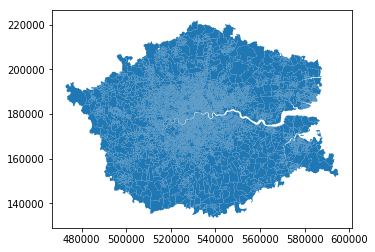

In [8]:
gdf.plot()

**Some questions for you:**

1. What type of data structure is the CRS attribute of the geopandas data frame?
2. How would you confirm this?
3. Can you figure out how to reproject the data using the geopandas documentation?
4. What is the data structure of the geometry column (broadly)?
5. Are there any differences between what a similar pandas data frame would give you if you ran any of the non-geographic commands?

## Working with PySAL

Now that we've prepared the raw data, we're ready to begin a more substantive analysis using PySAL. Of course, at this stage we're still going to take it fairly easy and not jump feet-first into using concepts like spatial autocorrelation or spatially-aware statistics.

In [ ]:
from pylab import *
from pysal.contrib import pdio
from pysal.contrib.viz import mapping as maps

**_Breaking News!_** Before we get into the guts of PySAL, I wanted to draw your attention to a _brand new_ feature in PySAL 1.13: much tighter integration with/support for pandas. It is now possible to ask PySAL to read a Shapefile or DBF file and return it to you as a pandas dataframe. This expands the range of options for working with geographical data by a significant amount:

```python
table_path = ps.examples.get_path('south.dbf') # Get a sample data set from PySAL
table = ps.pdio.read_files(table_path) # pdio = pandas I/O (input/output)
table.head() # It's a pandas dataframe!
ps.weights.Queen.from_dataframe(table) # Create weights from dataframe
```

You can find out more about the _new_ functions available [here](http://nbviewer.jupyter.org/gist/ljwolf/b960c198742eb26c335d9e32bdc7b76c?flush_cache=true)

### Reading a Shapefile in PySAL

Let's load a shapefile of London LSOAs -- these are the geographical boundaries for the NS-SeC data that you were working with last term. We kept geography out of it since getting to grips with Python is hard work enough, but now we want to begin exploring how adding space to our analysis starts to change _many_ things...

In [ ]:
lsoas = ps.open(os.path.join('shapes','LDN-LSOAs.shp'))
print("LSOAs class is: " + str(type(lsoas)))
print("There are " + str(len(lsoas)) + " polygons in the LSOA Shapefile.")
print("Shapefile headers:")
lsoas.header

In [ ]:
listings = ps.open(os.path.join('data','airbnb','listings-summary.shp'))
print("There are " + str(len(listings)) + " points in the listings summary Shapefile.")
listings.header # See what we loaded

### Revisiting Classification

Like pandas/geopandas, PySAL has a classification 'engine' that we can use to bin data based on attribute values. You might wonder why PySAL has its own process when we can already do this within pandas -- there are two reasons: first, now that we've got a shapefile we don't _really_ need to use pandas/geopandas any more and can do our work solely using PySAL; second, PySAL has additional classification methods that are _specific_ to geographic analysis problems. 

The best-known of these is Fisher-Jenks (also sometimes known as 'Natural Breaks'), which groups data into bins based on the sum of squared deviations between classes: in other words, the algorithm iteratively looks for ways to group the data into a specified number of bins such that moving a data point from one group to another would increase the total within-class deviation observed in the data.

But first, let's just go with quantiles and see how you can now work only with PySAL:

In [ ]:
# Notice: listingsdata != listings (DBF != SHP)
listingsdata = ps.open(os.path.join('data','airbnb','listings-summary.dbf'))
print("There are " + str(len(listingsdata)) + " rows in the listings summary DBF.")
listingsdata.header # See what we loaded

prices = np.array(listingsdata.by_col['price']) # Retrieve pricing data
pricesq5 = ps.esda.mapclassify.Quantiles(prices, k=5) # Classify into 5 quantiles
print(pricesq5) # Show the classification result

In [ ]:
pricesq5.yb # Check the class assignment

In [ ]:
# dir(maps) # If you want to explore this class
# help(maps.map_poly_shp) # And here's how we plot polygons!
fig = figure(figsize=(8,6))

base = maps.map_poly_shp(lsoas)
base.set_facecolor('none')
base.set_linewidth(0.5)
base.set_edgecolor('0.8')

lyr = maps.map_point_shp(listings)
lyr = maps.base_choropleth_classif(lyr, pricesq5.yb)
lyr.set_alpha(0.5)
lyr.set_linewidth(0.)
lyr.set_sizes(np.repeat(2.5, len(listingsdata)))

ax = maps.setup_ax([base, lyr], [lsoas.bbox, listings.bbox])
fig.add_axes(ax)
show()

Let's unpick the steps involved in this process:

First, we create the figure and specify an output size (this was done in 'inches' [as the screen sees them] but you can specify other units as well such as pixels and cm):
```python
fig = figure(figsize=(8,6)) # Set the output size in 'inches'
```

Next, we create a 'base' map that uses the LSOA polygons loaded from the LDN-LSOA Shapefile:
```python
base = maps.map_poly_shp(lsoas) # Create a polygon map from the LSOA object
base.set_facecolor('none')      # Set the colour of the 'face' (i.e. interior of the polygon)
base.set_linewidth(0.5)         # Set the width of the edge
base.set_edgecolor('0.8')       # Set the colour of the edge (this is a light grey)
```

Now we'll create another map, this one containing the AirBnB points loaded from the listings shapefile that we created earlier:
```python
lyr = maps.map_point_shp(listings) # Create a point map from the AirBnB listings object
lyr = maps.base_choropleth_classif(lyr, pricesq5.yb) # Turn this into a choropleth 
lyr.set_alpha(0.5)                 # Set the transparency (a.k.a. alpha) to 50%
lyr.set_linewidth(0.)              # Set the line width around each point to 0
lyr.set_sizes(np.repeat(2.5, len(listingsdata))) # Set the size of the points to 2.5 (points?)
```

The final step is to add both 'layers' to our figure (so, technically, we could have moved the `fig` line down to here, but it's easier to figure out what's going on if we leave it up above):
```python
ax = maps.setup_ax([base, lyr], [lsoas.bbox, listings.bbox]) # Add layer _and_ bounding box
fig.add_axes(ax) # Specify the axes
show() # Done!

```
Notice that you have to set up the x and y axes (`setup_ax`) using two parameters: the first array contains the layer objects created using `maps.map_<type>_shp(...)`, and the second contains the bounding boxes (`bbox`) derived as part of that process. **Note:** you *cannot* find the `bbox` on the object created using `maps...`, it is associated with the original object created using PySAL (`ps.open(...)`).

Another example, this time using Fisher-Jenks. Notice how the results look very, very different and how the boundaries between bins have been radically altered but also capture a bit better our intuition as to how the data can be represented.

In [ ]:
prices = np.array(listingsdata.by_col['price']) # Retrieve pricing data
pricesjk = ps.esda.mapclassify.Fisher_Jenks(prices, k=5) # Classify into 5 quantiles
print(pricesjk) # Show the classification result

To make it easier to see what's happening in Central London why don't we try zooming in a little bit? Notice that in the previous example we passed in the _bounding box_ as part of the axes command. Have a look at how the `listings.bbox` is set up and see if you can't figure out how to zoom in to something like:

Dimension | Max/Min | Value 
--------- | ------- | -----
Northing | Max | 190000
Northing | Min | 170000
Easting | Max | 540000
Easting | Min | 520000

In [ ]:
print(listings.bbox)
my_bbox = ???

In [ ]:
# To find out more about setting colours:
# help(plt.cm)
# help(maps.base_choropleth_classif)

fig = figure(figsize=(7,7)) # Why do you think I changed the figure size this way?

base = maps.map_poly_shp(lsoas)
base.set_facecolor('none')
base.set_linewidth(0.5)
base.set_edgecolor('0.8')

lyr = maps.map_point_shp(listings)
lyr = maps.base_choropleth_classif(???, cmap='viridis')
lyr.set_alpha(0.5)
lyr.set_linewidth(0.)
lyr.set_sizes(np.repeat(5, len(listingsdata))) # Sice of the dots

plt.title("Fisher-Jenks Classification of AirBnB Sample")
ax = maps.setup_ax([base, lyr], [???, ???]) # You should get a 'crop' of London
fig.add_axes(ax)
show()

We can also look at how the Fisher-Jenks classification relates to the underlying distribution by plotting the prices and bin boundaries derived by PySAL:

In [ ]:
sns.kdeplot(prices, shade=True)
for b in pricesjk.bins:
    plt.vlines(b, 0, 0.011, color='red', linestyle='--')

## Testing Your Understanding

Over to you! I'd like you to test [a number of the `mapclassify` options](http://pysal.readthedocs.io/en/latest/library/esda/mapclassify.html) and make up your own mind as to which is the 'best' for classifying the AirBnB data for London. To do this you will need to think about how you can automate the steps we've taken above, including:

* Loading the data
* Running the classifer
* Outputting it to a map
* Outputting the distribution with bin boundaries
* Looking at 'goodness-of-fit' metrics (see the documentation)

To make sure that you've done all of this correctly you should be able to click on 'Kernel' > 'Restart' and then run _only_ the code in the block below fully and successfully. So you'll need to factor in things like loading the libraries that you'll need, telling the notebook where to find the data, etc.